# Molecular Dynamics and Trajectory Analysis

Based on  https://github.com/pablo-arantes/making-it-rain
https://prolif.readthedocs.io/en/stable/notebooks/md-ligand-protein.html

In this session, we will perform a short molecular dynamics (MD) simulation of the protein-ligand complex. We will use the [OpenMM](https://openmm.org) software to conduct this calculation. The MD simulation produces a final structure and a trajectory. We will perform a series of sample analysis on the trajectory to probe the motion of the ligand within the binding site.


To run the notebook:

1. Connect to a Google Colab Runtime by clicking on the down-arrow next to the `Connect` button on the upper left, select `Change runtime type`, and selecting a `T4` GPU. Then click `Connect`.
2. Execute the first cell to install `condacolab`. Google Colab will restart. When done, move to the following cells.
3. Execute the second cell to install the required software components then execute the third to test that the software is working.
4. At this point, you are at the `Create Working Directory and Upload Files` cell. Here enter the name of directory where the calculation will be performed. Any name within the `/content` colab folder that makes sense to you is fine. Avoid spaces.
    *  The cell will create the folder
    *  Using the file browser, navigate to the folder and upload the structure input files into it
    *  The workflow needs the pdb file of the protein-ligand complex we prepared in Maestro in Session 3.2
    *  It also needs the `.sdf` file of the the ligand already docked to the receptor.
5. The following group of cells, named `View Final Structure and Trajectory` lets you view the structure of the complex at the end of the simulation and the trajectory (the latter did not work on my laptop, try it anyway). Adjust the residue ids of the binding site residues to match those in the paper.
6. The next two cells display the structures of the two ligands with the atoms labeled by atom index. Pick three atoms of each ligand that will serve as "alignment" atoms to superimpose the two ligands. These atoms are usually picked in the rigid common core of the ligands. They cannot be co-linear.
7. The following cells run a series of analysis of the trajectory:
  - Ligand RMSD to track the motion of the ligand relative to the receptor
  - Distance between the ligand and the binding site residues
  - Portein-ligand interaction diagram (saved to `Interaction.html`)
8. The final cell helps you download the simulation results to your laptop.



In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
# !pip install -q condacolab
# import condacolab
# condacolab.install()
!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh")

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [1]:
##@title **Install dependencies**
##@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
## install dependencies
import subprocess
import sys

#fixes sys.path that gives torchvision import error
original_syspath = sys.path.copy()
print(original_syspath)
new_syspath = ['/content', '/env/python', '/usr/local/lib/python312.zip', '/usr/local/lib/python3.12', '/usr/local/lib/python3.12/lib-dynload', '/usr/local/lib/python3.12/site-packages' ]
sys.path = new_syspath
print(sys.path)

subprocess.run("mamba install openmm openmmforcefields ambertools espaloma setproctitle r-base pdbfixer openbabel parmed mdtraj nglview mdanalysis -y", shell=True)
subprocess.run("Rscript -e 'install.packages(\"UWHAM\", repos = \"http://cran.us.r-project.org\")'", shell=True)
subprocess.run("pip install prolif==1.1.0", shell=True)

#latest version of AToM-OpenMM
subprocess.run("cd /content && git clone https://github.com/Gallicchio-Lab/AToM-OpenMM.git", shell=True)
subprocess.run("cd /content/AToM-OpenMM && pip install .", shell=True, capture_output=True, text=True)


['/usr/local/lib/python3.12/site-packages', '/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython']
['/content', '/env/python', '/usr/local/lib/python312.zip', '/usr/local/lib/python3.12', '/usr/local/lib/python3.12/lib-dynload', '/usr/local/lib/python3.12/site-packages']


CompletedProcess(args='cd /content/AToM-OpenMM && pip install .', returncode=0, stdout="Processing /content/AToM-OpenMM\n  Installing build dependencies: started\n  Installing build dependencies: finished with status 'done'\n  Getting requirements to build wheel: started\n  Getting requirements to build wheel: finished with status 'done'\n  Preparing metadata (pyproject.toml): started\n  Preparing metadata (pyproject.toml): finished with status 'done'\nCollecting configobj (from atom-openmm==8.4.1b0)\n  Downloading configobj-5.0.9-py2.py3-none-any.whl.metadata (3.2 kB)\nRequirement already satisfied: numpy in /usr/local/lib/python3.12/site-packages (from atom-openmm==8.4.1b0) (1.26.4)\nRequirement already satisfied: six in /usr/local/lib/python3.12/site-packages (from atom-openmm==8.4.1b0) (1.17.0)\nDownloading configobj-5.0.9-py2.py3-none-any.whl (35 kB)\nBuilding wheels for collected packages: atom-openmm\n  Building wheel for atom-openmm (pyproject.toml): started\n  Building wheel f

In [2]:
import openmm.testInstallation
openmm.testInstallation.main()


OpenMM Version: 8.4
Git Revision: 47684368dbbe4185d068be77d32a962059cfc37c

There are 4 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Error computing forces with CUDA platform
4 OpenCL - Successfully computed forces

CUDA platform error: Error loading CUDA module: CUDA_ERROR_UNSUPPORTED_PTX_VERSION (222)

Median difference in forces between platforms:

Reference vs. CPU: 6.29275e-06
Reference vs. OpenCL: 6.74321e-06
CPU vs. OpenCL: 7.94052e-07

All differences are within tolerance.


In [3]:
#@title ### **Create Working Directory and Upload Files**
import os
workDir = '/content/md-lig28' #@param {type:"string"}
os.makedirs(workDir, exist_ok=True)

In [5]:
#@title ### **Prepare system in a box of water and runs MD**
from openmm import *
from openmm.app import *
from openmm.unit import *
from atom_openmm.make_atm_system_from_rcpt_lig import make_system
from pathlib import Path

Protein_PDB_file_name = 'hpk1.pdb' #@param {type:"string"}
Ligand_SDF_file_name = "lig28.sdf" #@param {type:"string"}
Displacement_vector_in_Angstroms = [0.0, 0.0, 0.0]
simulation_time_in_ns = "1.0" #@param {type:"string"}
timestep = 0.002*picosecond
mdtime = float(simulation_time_in_ns) * nanoseconds
mdsteps = int(mdtime/timestep)
nprnt = int(mdsteps/100)
ntrj = nprnt

rcpt_pdb = workDir + '/' + Protein_PDB_file_name
ligand_sdf = workDir + '/' + Ligand_SDF_file_name

basename = Path(Protein_PDB_file_name).stem + \
  '-' + \
  Path(Ligand_SDF_file_name).stem

sysxml = workDir + '/' + basename + '_sys.xml'
syspdb = workDir + '/' + basename + '.pdb'

make_system(
      receptorfile=rcpt_pdb,
      lig1file=ligand_sdf ,
      displacement = Displacement_vector_in_Angstroms,
      xmloutfile=sysxml,
      pdboutfile=syspdb,
      ionicstrength=0.15,
)

pdb = PDBFile(syspdb)
topology = pdb.topology
positions = pdb.positions
boxvectors = topology.getPeriodicBoxVectors()
with open(sysxml) as input:
    system = XmlSerializer.deserialize(input.read())

integrator = LangevinMiddleIntegrator(298*kelvin, 1/picosecond, timestep)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
e_first = simulation.context.getState(getEnergy = True).getPotentialEnergy()
print("Potential energy before energy minimization =", e_first)
simulation.minimizeEnergy()
e_bound = simulation.context.getState(getEnergy = True).getPotentialEnergy()
print("Potential energy after energy minimization =", e_bound)

#pdb after minimization
minpos = simulation.context.getState(getPositions=True).getPositions()
syspdbmin = workDir + '/' + basename + '_min.pdb'
PDBFile.writeFile(topology, minpos, open(syspdbmin,'w'), keepIds=True)

#set initial velocities at 50K
simulation.context.setVelocitiesToTemperature(50.0*kelvin)

#runs MD
simulation.reporters.append(
      StateDataReporter(sys.stdout, nprnt, step=True, time=True,
                        potentialEnergy=True, temperature=True, progress=True,
                        remainingTime=True, speed=True,
                        totalSteps=mdsteps,
                        separator='\t') )
trjfile = workDir + '/' + basename + '_1.xtc'
simulation.reporters.append(XTCReporter(trjfile, ntrj, enforcePeriodicBox=False))
simulation.step(mdsteps)

#write restart file
state = simulation.context.getState( getPositions=True, getVelocities=True )
rstfile = workDir + '/' + basename + '_1.xml'
with open(rstfile, 'w') as f:
        f.write(XmlSerializer.serialize(state))

# Write pdb file
pos = simulation.context.getState(getPositions=True).getPositions()
pdboutfile = workDir + '/' + basename + '_1.pdb'
PDBFile.writeFile(topology, pos, open(pdboutfile, 'w'), keepIds=True)

print("MD done!")

Generate ATM RBFE OpenMM System

Date and time at start:  Mon Jan 12 23:16:12 2026

User-supplied input parameters
Receptor file name:                  /content/md-lig28/7l25.pdb
Protein force field:                 ['amber14-all.xml']
Solvent/ion force field              ['amber14/tip3p.xml']
Ligand force field:                  openff-2.0.0
Ligand 1 file name:                  None
Topology PDB output file:            /content/md-lig28/7l25-lig1.pdb
System XML output file:              /content/md-lig28/7l25-lig1_sys.xml
Force field cache file:              None
Call ForceField for protein and water
Receptor in PDB format
Number of atoms in receptor: 4633
Call Modeller: include receptor
Calculating receptor bounding box:
Areas of faces [23.821986799999998 nm**2, 26.949222699999996 nm**2, 33.700421 nm**2]
Direction of smallest area dimension: 0
Read ligand 1 from /content/md-lig28/lig1.sdf:
Number of atoms in ligand 1: 73
Call Modeller: include ligand 1
Calculating system bounding box

/usr/local/lib/python3.12/site-packages/smirnoff99frosst/smirnoff99frosst.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


Ionic strength =  0.15 M
Adding solvent and processing system ...
Number of atoms in solvated system: 35975


Date and time at end:    2026-01-12 23:17:59.564961

Total compute time 107.187 seconds
Potential energy before energy minimization = -220946.55415692367 kJ/mol
Potential energy after energy minimization = -576081.0559879784 kJ/mol
#"Progress (%)"	"Step"	"Time (ps)"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
1.0%	5000	10.000000000000009	-460852.37630047835	296.97693856147765	0	--
2.0%	10000	19.999999999999794	-461286.61848797835	300.050111880631	153	9:14
3.0%	15000	29.99999999999425	-460617.56380047835	298.02448946284306	151	9:16
4.0%	20000	40.00000000000292	-461362.95051922835	299.02025951254797	150	9:11
5.0%	25000	50.00000000001514	-461382.38606610335	297.3989980130246	150	9:08
6.0%	30000	60.00000000002736	-461058.40169110335	298.54138776916454	149	9:04
7.0%	35000	70.00000000001826	-462214.72493329085	299.54620935446246	148	9:01
8.0%	4000

# View Final Structure and Trajectory

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

In [7]:
#@title View final structure
import nglview as nv
view = nv.show_structure_file(pdboutfile, height='600px', default_representation=False)
view.add_cartoon("protein")
view.add_ball_and_stick("L1")
view.add_ball_and_stick("87 88 89 96 150") #binding site residues
view

NGLWidget()

In [8]:
#@title View trajectory (did not work on my laptop)
import nglview as nv
import MDAnalysis as mda
from pathlib import Path

u = mda.Universe(pdboutfile, trjfile)
print("Number of frames: ", u.trajectory.n_frames) # print the number of frames
view = nv.show_mdanalysis(u, height='600px')
view.add_cartoon("protein")
view.add_ball_and_stick("87 88 89 96 150") #binding site residues
view.add_ball_and_stick('L1')
view

/usr/local/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:309: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


Number of frames:  100


NGLWidget(max_frame=99)

/usr/local/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:309: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


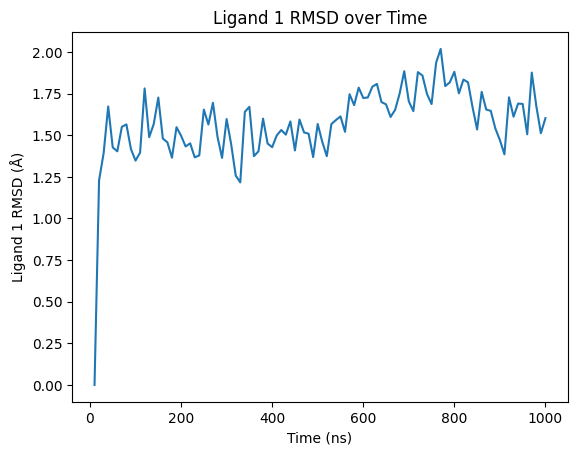

In [9]:
#@title ### **Ligand RMSD**

import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD
import pandas as pd
import matplotlib.pyplot as plt

u = mda.Universe(syspdb, trjfile, ref_frame=0)
ligand = 'resname L1'

rms_calc = RMSD(u, u, select=ligand)
rms_calc.run()

df = pd.DataFrame(rms_calc.results.rmsd, columns=['Frame', 'Time (ns)', 'RMSD'])
plt.plot(df['Time (ns)'], df['RMSD'])
plt.xlabel('Time (ns)')
plt.ylabel('Ligand 1 RMSD (Å)')
plt.title('Ligand 1 RMSD over Time')
plt.show()

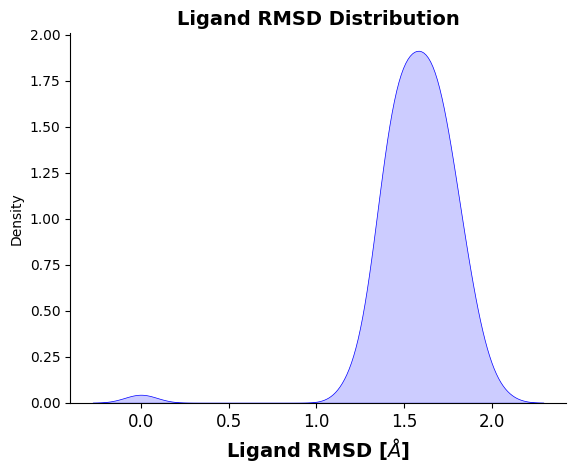

In [10]:
#@title ### **Ligand RMSD as a distribution**

import seaborn as sb

Output_name = 'rmsd_dist' #@param {type:"string"}

selected_columns = ['Time (ns)', 'RMSD']

# Create a new dictionary using a dictionary comprehension
new_dict = {key: df[key] for key in selected_columns if key in df}

ax = sb.kdeplot(new_dict['RMSD'], color="blue", fill=True, alpha=0.2, linewidth=0.5)
plt.xlabel(r'Ligand RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.title(r'Ligand RMSD Distribution', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
#plt.yticks([])
plt.ylabel('Density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

/usr/local/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:309: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


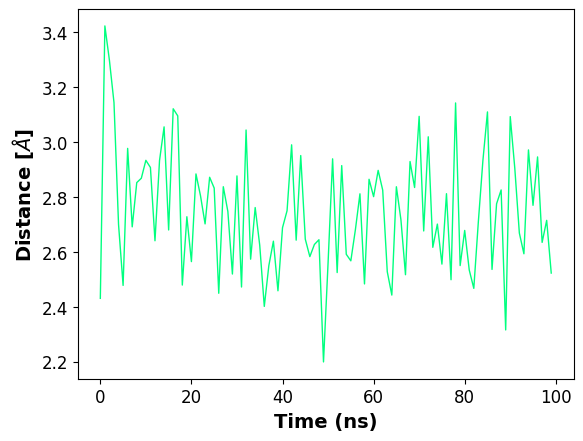

In [11]:
#@title **Compute distance between the ligand and catalytic site residues**
#@markdown **Provide output file names below:**
Output_name = 'distance' #@param {type:"string"}
#@markdown **Distance to nearest residues (Angstroms):**
Ligand_selection = "resname L1" #@param {type:"string"}
Residue_ID_selections = "resid 87 88 89 96 150 and not name H*" #@param {type:"string"}

import MDAnalysis as mda
from MDAnalysis.analysis import distances
import numpy as np

u = mda.Universe(syspdb, trjfile, ref_frame=0)
#ligand 1 selection
ligand = u.select_atoms(Ligand_selection)
#catalytic site selection
cat_site = u.select_atoms(Residue_ID_selections)

#this gives the closest atom–atom distance between ligand and catalytic site over a trajectory.
dmin_series = []
for ts in u.trajectory:
    d = distances.distance_array(
        ligand.positions,
        cat_site.positions,
        box=u.dimensions,
    ).min()
    dmin_series.append(d)

dmin_series = np.array(dmin_series)

ax = plt.plot(dmin_series, alpha=1, color = 'springgreen', linewidth = 1.0)
plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel(r"Distance [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')


Text(0.5, 1.0, 'Ligand-CatSite Distance Distribution')

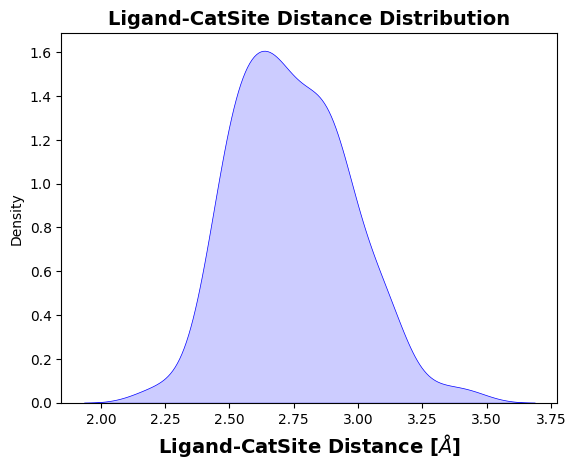

In [12]:
#@title **Compute distance distribution the ligand and catalytic site residues**

ax2 = sb.kdeplot(dmin_series, color="blue", fill=True, alpha=0.2, linewidth=0.5)
plt.xlabel(r'Ligand-CatSite Distance [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.title('Ligand-CatSite Distance Distribution', fontsize = 14, fontweight = 'bold')

In [13]:
#@title **View and check the Ligand Interaction Network (LigPlot) during MD simulations**
#@markdown This diagram is interactive and allows moving around the residues, as well as clicking the legend to toggle the display of specific residues types or interactions. The diagram will be saved as an HTML file (output.html).

#@markdown **Provide output file names below:**
Output_name = 'Interaction' #@param {type:"string"}

#@markdown The frequency with which an interaction is seen will control the width of the corresponding edge. You can hide the least frequent interactions by using a threshold, i.e. threshold=0.3 will hide interactions that occur in less than 30% of frames.
Threshold = 0.3 #@param {type:"slider", min:0, max:1.0, step:0.1}

import MDAnalysis as mda
import prolif as plf
import numpy as np
import os
from prolif.plotting.network import LigNetwork

# load topology
u = mda.Universe(syspdb, trjfile, ref_frame=0)
# select atoms
lig = u.select_atoms("resname L1")
prot = u.select_atoms("protein")

# create RDKit-like molecules for visualization
lmol = plf.Molecule.from_mda(lig)
pmol = plf.Molecule.from_mda(prot)
print(lmol, pmol)

fp = plf.Fingerprint()
fp.run(u.trajectory[::int(u.trajectory.n_frames/20)], lig, prot)
df = fp.to_dataframe(return_atoms=True)
print(df)

net = LigNetwork.from_ifp(df, lmol,
                          # replace with `kind="frame", frame=0` for the other depiction
                          kind="aggregate", threshold=float(Threshold),
                          rotation=270)
net.save(os.path.join(workDir, Output_name + ".html"))
net.display()

/usr/local/lib/python3.12/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)
/usr/local/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:309: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


<prolif.molecule.Molecule with 1 residues and 73 atoms at 0x793ea7b78f90> <prolif.molecule.Molecule with 291 residues and 4633 atoms at 0x793ea7c35df0>


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/site-packages/prolif/utils.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=["ligand", "protein", "interaction"]).agg(tuple)


ligand              L10.L                                            \
protein          ALA136.A       GLY20.A       SER93.A       TYR23.A   
interaction    VdWContact    VdWContact    VdWContact    VdWContact   
Frame                                                                 
0            (None, None)  (None, None)  (None, None)        (9, 0)   
5            (None, None)        (6, 0)  (None, None)  (None, None)   
10           (None, None)  (None, None)  (None, None)  (None, None)   
15           (None, None)        (6, 0)  (None, None)  (None, None)   
20           (None, None)  (None, None)       (66, 0)  (None, None)   
25           (None, None)  (None, None)  (None, None)  (None, None)   
30           (None, None)  (None, None)  (None, None)  (None, None)   
35                (40, 0)  (None, None)       (66, 0)  (None, None)   
40           (None, None)  (None, None)  (None, None)  (None, None)   
45           (None, None)  (None, None)  (None, None)  (None, None)   
50    

/usr/local/lib/python3.12/site-packages/prolif/plotting/network.py:293: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ifp.applymap(lambda x: x[0]).astype(object), prefix_sep=", "


In [ ]:
#@title ### **Download the results as a zip file**
import zipfile
from google.colab import files

print("Downloading result files.")
filename = f'{workDir}.zip'

with zipfile.ZipFile(filename, 'w') as zip_file:
    dir_path = f'{workDir}'
    for root, directory, items in os.walk(dir_path):
        for item in items:
            path = os.path.join(root, item)
            zip_file.write(path, arcname=os.path.relpath(os.path.join(root, item), dir_path), compress_type=zipfile.ZIP_DEFLATED)

files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>